<a href="https://colab.research.google.com/github/nicolasvazquez95/cursos-python/blob/master/DeepLearning/5_Evaluacion_Modelos/ejercicios/ejercicios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejercicios de la clase 5

Para llevar adelante los ejercicios de este notebook vamos a recuperar los modelos que construimos en la clase 3 para clasificación sobre FashionMNIST.

In [1]:
import torch
from torch import nn

INPUT = 28 * 28 
OUTPUT = 10 

net1 = nn.Sequential(nn.Flatten(),
                    nn.Linear(INPUT, 512),
                    nn.ReLU(),
                    nn.Linear(512, 128),
                    nn.ReLU(),
                    nn.Linear(128, OUTPUT))

net2 = nn.Sequential(nn.Flatten(),
                    nn.Linear(INPUT, 512),
                    nn.Sigmoid(),
                    nn.Linear(512, 128),
                    nn.Sigmoid(),
                    nn.Linear(128, OUTPUT))

net3 = nn.Sequential(nn.Flatten(),
                    nn.Linear(INPUT, 1024),
                    nn.ReLU(),
                    nn.Linear(1024, 1024),
                    nn.ReLU(),
                    nn.Linear(1024, OUTPUT))

Ahora repetiremos la evaluación que hicimos en esa clase, pero llevándola adelante de manera más exhaustiva con K-fold Cross Validation. Para eso, cargaremos **solo los datos de testeo** de FasionMNIST y fingiremos que esos 10000 ejemplos son todos los que tenemos.

In [2]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

data_iter = datasets.FashionMNIST(
        root="../data", train=False, transform=transforms.ToTensor(), download=True)

## Ejercicio 
Verifique cuál de los modelos anteriores es el mejor llevando adelante proceso de cross validation con 3 folds y entrenando por 20 epochs. Reutilice todas las funciones que necesite de los notebooks de teoría de la clase 5 y de todos los ejercicios anteriores.

Nota: le recomendamos que guarde las accuracy tanto de testeo como de entrenamiento porque le servirán para más adelante.

In [3]:
from sklearn.model_selection import KFold

def reset_weights(m):
  if type(m) == nn.Linear:
      nn.init.normal_(m.weight, std=0.01)

def train(fold, model, device, loss, train_loader, optimizer, epoch):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        l = loss(model(data), target).mean()
        l.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Fold/Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                fold,epoch, batch_idx * len(data), len(train_loader.sampler.indices),
                100. * batch_idx / len(train_loader), l.item()/len(target)))

def accuracy(y_hat, y):
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

    
def test_accuracy(fold,model, loss, device, test_loader):
  # inserte su código aquí
  TestAcc = 0.0
  N = 0
  for X, y in test_loader:
      X, y = X.to(device), y.to(device)
      N += y.numel()
      TestAcc += accuracy(model(X), y)
  print('\nTest set for fold {}:  Accuracy: {}/{} ({:.0f}%)\n'.format(
        fold, TestAcc, N,
        (100. * TestAcc) / N))
  return TestAcc / N

kfold=KFold(n_splits=5,shuffle=True)
batch_size=32

In [8]:
def train_KFold(net,dataset,loss,folds,epochs,batch_size):
  acc_fold = []
  optimizer = torch.optim.Adam(net.parameters())
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
  kfold = KFold(n_splits=folds)
  for fold,(train_idx,test_idx) in enumerate(kfold.split(dataset)):
    acc_epoch = []
    print(f'---Fold {fold+1}---')
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_idx)

    train_loader = torch.utils.data.DataLoader(dataset,
                                               batch_size=batch_size,
                                               sampler=train_subsampler)
    test_loader = torch.utils.data.DataLoader(dataset,
                                               batch_size=batch_size,
                                               sampler=test_subsampler)
    net.apply(reset_weights)

    for epoch in range(1,epochs+1):
      train(fold,net,device,loss,train_loader,optimizer,epoch)
      fold_acc = test_accuracy(fold,net,loss,device,test_loader)
      acc_epoch.append(fold_acc)
    acc_fold.append(acc_epoch)
  return acc_fold

In [6]:
loss = torch.nn.CrossEntropyLoss(reduction='none')

In [9]:
# Net1
results_net1 = train_KFold(net1,data_iter,loss,
                           folds=5,epochs=20,batch_size=32)

---Fold 1---
Train Fold/Epoch: 0/1 [0/8000 (0%)]	Loss: 0.071659

Test set for fold 0:  Accuracy: 1515.0/2000 (76%)

Train Fold/Epoch: 0/2 [0/8000 (0%)]	Loss: 0.025707

Test set for fold 0:  Accuracy: 1629.0/2000 (81%)

Train Fold/Epoch: 0/3 [0/8000 (0%)]	Loss: 0.014511

Test set for fold 0:  Accuracy: 1679.0/2000 (84%)

Train Fold/Epoch: 0/4 [0/8000 (0%)]	Loss: 0.012231

Test set for fold 0:  Accuracy: 1694.0/2000 (85%)

Train Fold/Epoch: 0/5 [0/8000 (0%)]	Loss: 0.007815

Test set for fold 0:  Accuracy: 1671.0/2000 (84%)

Train Fold/Epoch: 0/6 [0/8000 (0%)]	Loss: 0.015968

Test set for fold 0:  Accuracy: 1685.0/2000 (84%)

Train Fold/Epoch: 0/7 [0/8000 (0%)]	Loss: 0.011755

Test set for fold 0:  Accuracy: 1646.0/2000 (82%)

Train Fold/Epoch: 0/8 [0/8000 (0%)]	Loss: 0.007664

Test set for fold 0:  Accuracy: 1694.0/2000 (85%)

Train Fold/Epoch: 0/9 [0/8000 (0%)]	Loss: 0.013605

Test set for fold 0:  Accuracy: 1708.0/2000 (85%)

Train Fold/Epoch: 0/10 [0/8000 (0%)]	Loss: 0.011433

Test se

In [10]:
results_net2 = train_KFold(net2,data_iter,loss,
                           folds=5,epochs=20,batch_size=32)

---Fold 1---
Train Fold/Epoch: 0/1 [0/8000 (0%)]	Loss: 0.073144

Test set for fold 0:  Accuracy: 1273.0/2000 (64%)

Train Fold/Epoch: 0/2 [0/8000 (0%)]	Loss: 0.035257

Test set for fold 0:  Accuracy: 1464.0/2000 (73%)

Train Fold/Epoch: 0/3 [0/8000 (0%)]	Loss: 0.022453

Test set for fold 0:  Accuracy: 1564.0/2000 (78%)

Train Fold/Epoch: 0/4 [0/8000 (0%)]	Loss: 0.014817

Test set for fold 0:  Accuracy: 1634.0/2000 (82%)

Train Fold/Epoch: 0/5 [0/8000 (0%)]	Loss: 0.018663

Test set for fold 0:  Accuracy: 1667.0/2000 (83%)

Train Fold/Epoch: 0/6 [0/8000 (0%)]	Loss: 0.016747

Test set for fold 0:  Accuracy: 1686.0/2000 (84%)

Train Fold/Epoch: 0/7 [0/8000 (0%)]	Loss: 0.011688

Test set for fold 0:  Accuracy: 1700.0/2000 (85%)

Train Fold/Epoch: 0/8 [0/8000 (0%)]	Loss: 0.009387

Test set for fold 0:  Accuracy: 1667.0/2000 (83%)

Train Fold/Epoch: 0/9 [0/8000 (0%)]	Loss: 0.009969

Test set for fold 0:  Accuracy: 1699.0/2000 (85%)

Train Fold/Epoch: 0/10 [0/8000 (0%)]	Loss: 0.014068

Test se

In [11]:
results_net3 = train_KFold(net3,data_iter,loss,
                           folds=5,epochs=20,batch_size=32)

---Fold 1---
Train Fold/Epoch: 0/1 [0/8000 (0%)]	Loss: 0.072022

Test set for fold 0:  Accuracy: 1585.0/2000 (79%)

Train Fold/Epoch: 0/2 [0/8000 (0%)]	Loss: 0.020722

Test set for fold 0:  Accuracy: 1640.0/2000 (82%)

Train Fold/Epoch: 0/3 [0/8000 (0%)]	Loss: 0.019227

Test set for fold 0:  Accuracy: 1661.0/2000 (83%)

Train Fold/Epoch: 0/4 [0/8000 (0%)]	Loss: 0.022860

Test set for fold 0:  Accuracy: 1633.0/2000 (82%)

Train Fold/Epoch: 0/5 [0/8000 (0%)]	Loss: 0.006083

Test set for fold 0:  Accuracy: 1685.0/2000 (84%)

Train Fold/Epoch: 0/6 [0/8000 (0%)]	Loss: 0.013545

Test set for fold 0:  Accuracy: 1706.0/2000 (85%)

Train Fold/Epoch: 0/7 [0/8000 (0%)]	Loss: 0.010962

Test set for fold 0:  Accuracy: 1726.0/2000 (86%)

Train Fold/Epoch: 0/8 [0/8000 (0%)]	Loss: 0.016486

Test set for fold 0:  Accuracy: 1723.0/2000 (86%)

Train Fold/Epoch: 0/9 [0/8000 (0%)]	Loss: 0.008408

Test set for fold 0:  Accuracy: 1706.0/2000 (85%)

Train Fold/Epoch: 0/10 [0/8000 (0%)]	Loss: 0.019460

Test se

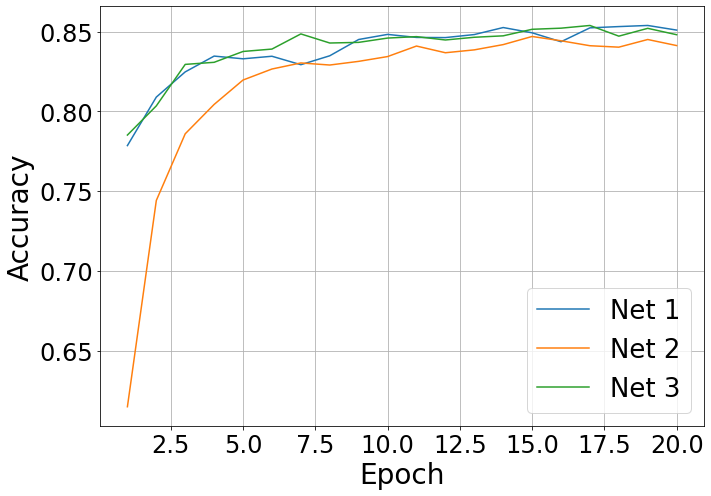

In [13]:
from matplotlib import pyplot as plt
import numpy as np
plt.figure(figsize=(10,7))
epochs = list(range(1,21))

plt.plot(epochs,np.mean(np.array(results_net1),axis=0),label='Net 1')
plt.plot(epochs,np.mean(np.array(results_net2),axis=0),label='Net 2')
plt.plot(epochs,np.mean(np.array(results_net3),axis=0),label='Net 3')

plt.xlabel('Epoch',size=28);plt.ylabel('Accuracy',size=28)
plt.xticks(size=24);plt.yticks(size=24)

plt.legend(fontsize=26)
plt.tight_layout()
plt.grid()
plt.show()